To Dos:
- Add sigma, phi and tau to optimization
  - How to draw from negative binomial with negative phi?
  - Tau as value to initialize y
  - why does sigma have a gradient of 0?
- Change loss function to negative log likelihood
- Toy Data
- Add prior knowledge to loss function
- Optimize for loops
- Check .clone() - Where do we need it and where is it redundant?



Haomann: Neg. Log Likelihood & Phi Variable
Anuar: Toy Data & Tau Variable
Timo: Sigma Variable

In [1]:
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncexpon, truncnorm, nbinom
import pandas as pd
import torch
from torch import nn

In [2]:
np.random.seed(seed=101)
torch.manual_seed(101)
torch.use_deterministic_algorithms(True)
dtype = torch.float
device = torch.device("cpu")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
cd /content/drive/MyDrive/CovidPrediction/

/content/drive/MyDrive/CovidPrediction


# Initialization

In [5]:
data = pd.read_csv('data/covid19model.csv')
data.head(3)

,date,hospit,serial_interval,delay_distr
0,2020-02-17,0,0.046535,0.013006
1,2020-02-18,0,0.087065,0.030046
2,2020-02-19,0,0.112061,0.044674


In [6]:
cero = torch.tensor(0, requires_grad=False, device=device, dtype=dtype)
num_impute = 6
observed_daily_hospit = torch.tensor(data.hospit, requires_grad=False, device=device, dtype=dtype)
pi = torch.tensor(data.delay_distr, requires_grad=False, device=device, dtype=dtype)
serial_interval = torch.tensor(data.serial_interval, requires_grad=False, device=device, dtype=dtype)
population = torch.tensor(5793636, requires_grad=False, device=device, dtype=dtype)
num_observations = len(observed_daily_hospit)

Initialize latent variables / parameters

In [7]:
tau = np.random.exponential(1 / 0.03)
#tau_t = torch.tensor(tau, requires_grad=True, device=device, dtype=dtype)
# b=(upper-lower)/scale, loc=lower, scale=scale
y = torch.tensor(truncexpon.rvs(b=(1000 - 0) / tau, loc=0, scale=tau), requires_grad=False, device=device, dtype=dtype)  # number of initial newly_infected (seed)

# For trunc ((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
#phi = torch.tensor(truncnorm.rvs((0 - 0) / 5, (np.inf - 0) / 5, loc=0, scale=5), requires_grad=True, device=device, dtype=dtype)  # dispersion (shape) parameter for observations
R0 = torch.tensor(truncnorm.rvs((2 - 3.6) / 0.8, (5 - 3.6) / 0.8, loc=3.6, scale=0.8), requires_grad=True, device=device, dtype=dtype)  # initial reproduction number
alpha = torch.tensor(truncnorm.rvs((0 - 1/100) / 1/100, (5/100 - 1/100) / 1/100, loc=1/100, scale=1/100), requires_grad=True, device=device, dtype=dtype)  # probability to get hospitalized
sigma = torch.tensor(truncnorm.rvs((0 - 0.05) / 0.03, (0.15 - 0.05) / 0.03, loc=0.05, scale=0.03), requires_grad=True, device=device, dtype=dtype)  # standart deviation of random walk step

Initialize time series variables

In [8]:
"""newly_infected = torch.zeros(num_observations)  # number of newly infected
effectively_infectious = torch.zeros(num_observations)  # effective number of infectious individuals
expected_daily_hospit = torch.zeros(num_observations)  # expected number of daily hospitalizations
cumulative_infected = torch.zeros(num_observations)  # cumulative number of infected
eta_t = torch.zeros(num_observations)  # transformed reproduction number
epsilon_t = torch.zeros(num_observations)  # random walk
St = torch.zeros(num_observations)  # fraction of susceptible population"""

'newly_infected = torch.zeros(num_observations)  # number of newly infected\neffectively_infectious = torch.zeros(num_observations)  # effective number of infectious individuals\nexpected_daily_hospit = torch.zeros(num_observations)  # expected number of daily hospitalizations\ncumulative_infected = torch.zeros(num_observations)  # cumulative number of infected\neta_t = torch.zeros(num_observations)  # transformed reproduction number\nepsilon_t = torch.zeros(num_observations)  # random walk\nSt = torch.zeros(num_observations)  # fraction of susceptible population'

seed initial infection / impute first `num_impute` days

In [9]:
"""newly_infected[0:num_impute] = y.clone()
cumulative_infected[0] = 0.
cumulative_infected[1:num_impute] = torch.cumsum(newly_infected[0:num_impute - 1].clone(), dim=0)
St[0:num_impute] = torch.tensor([torch.maximum(population.clone() - x, torch.tensor(0)) / population for x in cumulative_infected[0:num_impute].clone()])"""

'newly_infected[0:num_impute] = y.clone()\ncumulative_infected[0] = 0.\ncumulative_infected[1:num_impute] = torch.cumsum(newly_infected[0:num_impute - 1].clone(), dim=0)\nSt[0:num_impute] = torch.tensor([torch.maximum(population.clone() - x, torch.tensor(0)) / population for x in cumulative_infected[0:num_impute].clone()])'

# Define Forward Pass

In [16]:
def forward_pass():
  # Initialize time series variables
  newly_infected = torch.zeros(num_observations)  # number of newly infected
  effectively_infectious = torch.zeros(num_observations)  # effective number of infectious individuals
  expected_daily_hospit = torch.zeros(num_observations)  # expected number of daily hospitalizations
  cumulative_infected = torch.zeros(num_observations)  # cumulative number of infected
  eta_t = torch.zeros(num_observations)  # transformed reproduction number
  epsilon_t = torch.zeros(num_observations)  # random walk
  St = torch.zeros(num_observations)  # fraction of susceptible population

  # seed initial infection / impute first num_impute days
  newly_infected[0:num_impute] = y.clone()
  cumulative_infected[0] = 0.
  cumulative_infected[1:num_impute] = torch.cumsum(newly_infected[0:num_impute - 1].clone(), dim=0)
  St[0:num_impute] = torch.tensor([torch.maximum(population.clone() - x, torch.tensor(0)) / population for x in cumulative_infected[0:num_impute].clone()])

  # calculate Rt: the basic reproduction number
  beta_0 = torch.log(R0)
  epsilon_t[0] = torch.normal(cero, sigma)
  for t in range(1, num_observations):
      epsilon_t[t] = torch.normal(epsilon_t[t - 1].clone(), sigma)
  eta_t = beta_0 + epsilon_t  # + RNN[X_t, t]  # .clone() necessary?
  Rt = torch.exp(eta_t)

  # calculate infections
  for t in range(num_impute, num_observations):
      # Update cumulative newly_infected
      cumulative_infected[t] = cumulative_infected[t - 1].clone() + newly_infected[t - 1].clone()
      # Adjusts for portion of pop that are susceptible
      St[t] = torch.maximum(population.clone() - cumulative_infected[t].clone(), cero) / population.clone()
      # effective number of infectous individuals
      for i in range(0, t - 1):
          effectively_infectious[t] += newly_infected[i].clone() * serial_interval[t - i].clone()

      # number of new infections (unobserved)
  newly_infected[num_impute:num_observations] = St[num_impute:num_observations].clone() * Rt[num_impute:num_observations].clone() * effectively_infectious[num_impute:num_observations].clone() # .clone() necessary?

  # calculate expected number of hospitalizations
  expected_daily_hospit[0] = (1e-15) * newly_infected[0].clone()
  for t in range(1, num_observations):
      for i in range(0, t - 1):
          expected_daily_hospit[t] += newly_infected[i].clone() * pi[t - i].clone()
  expected_daily_hospit = alpha * expected_daily_hospit # .clone() necessary?

  return expected_daily_hospit

# Optimization

Time Step: 0, Loss: -inf, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 22.100324630737305
 R0:2.280816078186035, grad: -174.17593383789062, alpha: 0.08087945729494095 grad: -6331.16845703125, sigma: 0.06573405861854553 grad 0.0
Time Step: 1, Loss: -inf, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 24.21578598022461
 R0:2.281006336212158, grad: -190.3629608154297, alpha: 0.08723276108503342 grad: -6353.3017578125, sigma: 0.06573405861854553 grad 0.0
Time Step: 2, Loss: -inf, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 30.21767807006836
 R0:2.2812578678131104, grad: -251.5118865966797, alpha: 0.0947500467300415 grad: -7517.2841796875, sigma: 0.06573405861854553 grad 0.0
Time Step: 3, Loss: -inf, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 27.823978424072266
 R0:2.2814693450927734, grad: -211.49375915527344, alpha: 0.10079552233219147 grad: -6045.4755859375, sigma: 0.06573405861854553 grad 0.0
Time Step: 4, Loss: -inf, Observed_daily_hospit: 13199

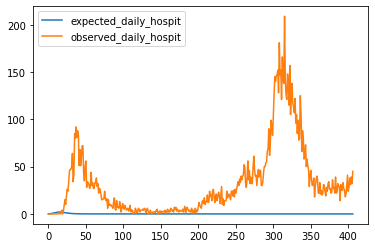

In [18]:
learning_rate = 1e-6

for t in range (10):
  # forward pass - calculate expected_daily_hospit
  expected_daily_hospit = forward_pass()

  loss = (observed_daily_hospit - expected_daily_hospit).pow(2).sum()
    # for i in 1:num_obs
    #   ℓ += logpdf( NegativeBinomial2(expected_daily_hospit[i], ϕ), observed_hospit[i])
  loss += truncnorm.logpdf(x=R0.detach().numpy() ,a=2, b=5, loc=0, scale=0.8)
  loss += truncnorm.logpdf(x=alpha.detach().numpy() ,a=0, b=5/100, loc=0, scale=1/100)
  loss.backward()

  print(f'Time Step: {t}, Loss: {loss}, Observed_daily_hospit: {torch.sum(observed_daily_hospit)}, Expected_daily_hospit: {torch.sum(expected_daily_hospit)}')
  

  with torch.no_grad():
    #tau_t -= learning_rate * tau_t.grad
    #phi -= learning_rate * phi.grad
    R0 -= learning_rate * R0.grad
    alpha -= learning_rate * alpha.grad
    sigma -= learning_rate * sigma.grad
    print(f' R0:{R0}, grad: {R0.grad}, alpha: {alpha} grad: {alpha.grad}, sigma: {sigma} grad {sigma.grad}' )

    #tau_t.grad = None
    #phi.grad = None
    R0.grad = None
    alpha.grad = None
    sigma.grad = None
  
plt.plot(expected_daily_hospit.detach().numpy(), label='expected_daily_hospit')
plt.plot(observed_daily_hospit.detach().numpy(), label='observed_daily_hospit')
plt.legend()
plt.show()

compare observed hospitalizations to model results

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(expected_daily_hospit.detach().numpy(), label='expected_daily_hospit')
plt.plot(observed_daily_hospit.detach().numpy(), label='observed_daily_hospit')
plt.legend()
plt.show()